In [1]:
# 15/05/2020, B. M. Giblin, Edinburgh
# Tidying up codes that plot rho/Paulin-Henriksson stats
# by having some of the functio

import numpy as np
from scipy.stats import binned_statistic_2d
from astropy.io import fits
import time
import glob
import h5py

def interpolate2D(X, Y, grid): #(It's linear)                                                                    
    # This function does simple 2D linear interpolation to find values of 'grid' at positions (X,Y)
    # This is faster over, eg, scipy and numpy functions, which have to be performed in a loop.  
    print("interpolate")
    Xi = X.astype(int)
    Yi = Y.astype(int) # these round down to integer                                                       
    VAL_XYlo = grid[Yi, Xi] + (X - Xi)*( grid[Yi, Xi+1] - grid[Yi, Xi] )
    VAL_XYhi = grid[Yi+1,Xi] + (X - Xi)*( grid[Yi+1,Xi+1] - grid[Yi+1, Xi] )
    VAL_XY = VAL_XYlo + (Y - Yi)*( VAL_XYhi - VAL_XYlo )
    return VAL_XY

def Select_Patch(Q, ra, dec, rlo, rhi, dlo, dhi):
    print("select patch")
    # return the elements in Q corresponding to INSIDE the (ra,dec) range
    idx_ra = np.where(np.logical_and(ra<rhi, ra>rlo))[0]
    idx_dec = np.where(np.logical_and(dec<dhi, dec>dlo))[0]
    idx = np.intersect1d(idx_ra, idx_dec)
    return Q[idx]


def MeanQ_VS_XY(Q, w, X,Y,num_XY_bins):
    print("mean q vs xy")
    # we want the weighted mean of Q.
    # Calculate the sum 2D binned value of Q*w and w, and then divide
    sumQw_grid, yedges, xedges, binnum = binned_statistic_2d(Y, X, Q*w, statistic='sum', bins=num_XY_bins)
    sum_w_grid, yedges, xedges, binnum = binned_statistic_2d(Y, X, w, statistic='sum', bins=num_XY_bins)
    AvQ_grid=sumQw_grid/sum_w_grid
    return AvQ_grid,sum_w_grid,yedges,xedges

def Bootstrap_Error(nboot, samples, weights):
    print('bootstrap')
    N = len(samples)
    bt_samples = np.zeros(nboot)                            # Will store mean of nboot resamples              
    for i in range(nboot):
        idx = np.random.randint(0,N,N)                      # Picks N random indicies with replacement        
        bt_samples[i] = np.sum( weights[idx]*samples[idx] ) /np.sum (weights[idx])
    return np.std( bt_samples )



def Read_GalData(Field):    
    # Use the Master catalogue:   
    path = '/global/cfs/cdirs/lsst/groups/WL/projects/txpipe-sys-tests/hsc-y3/shear/'
    if Field == 'GAMA09H':
        file = path+'GAMA09H_calibrated.fits'
    elif Field == 'GAMA15H':
        file = path+'GAMA15H_calibrated.fits'
    elif Field == 'HECTOMAP':
        file = path+'HECTOMAP_calibrated.fits'
    elif Field == 'VVDS':
        file = path+'VVDS_calibrated.fits'
    elif Field == 'XMM':
        file = path+'XMM_calibrated.fits'
    elif Field == 'WIDE12H':
        file = path+'WIDE12H_calibrated.fits'

    f = fits.open(file.format(field=Field))[1].data
    RA = f['i_ra']
    Dec= f['i_dec']
    Z  = f['hsc_y3_zbin']

    T_gal = f['i_sdssshape_shape11']+f['i_sdssshape_shape22']
    T_PSF = f['i_sdssshape_psf_shape11']+f['i_sdssshape_psf_shape22']
    weight= f['i_hsmshaperegauss_derived_weight']            

    return RA, Dec, T_gal, T_PSF, weight, Z


def Interp_deltaT(RA_g, Dec_g, RA_p, Dec_p, delta_TPSF):
    # This function interpolates delta_TPSF to the galaxy positions
    
    # To grid up the survey, decide on a suitable angular size a pixel should be:                                     
    # Use the dimensions of the PSF data (_p), not gal data (_g),                                                     
    # as the PSF data spans wider (RA,Dec)                                                                            
    ang_pxl = 5. / 60. # 5 arcmin in degrees                                                                          
    nbins_x = int( ( RA_p.max()-RA_p.min() ) / ang_pxl )
    nbins_y = int( ( Dec_p.max()-Dec_p.min() ) / ang_pxl )
    
    # pixel coordinates of the PSF objects                                                                            
    X_p = nbins_x * (RA_p - RA_p.min()) / (RA_p.max()-RA_p.min())
    Y_p = nbins_y * (Dec_p - Dec_p.min()) / (Dec_p.max()-Dec_p.min())

    # Turn delta_TPSF into a grid:                                                                                    
    delta_TPSF_grid,count_grid, _,_ = MeanQ_VS_XY(delta_TPSF, np.ones_like(delta_TPSF),
                                                  X_p,Y_p, [nbins_y,nbins_x])
    delta_TPSF_grid = np.nan_to_num( delta_TPSF_grid, nan=0. ) # Lots of nans due to 0/0 

    # Need to append TPSF_grid with final rows and columns to avoid interp error  
    delta_TPSF_grid = np.c_[ delta_TPSF_grid, delta_TPSF_grid[:,-1] ]
    delta_TPSF_grid = np.r_[ delta_TPSF_grid, [delta_TPSF_grid[-1,:]]]

    # pixel coordinates of galaxies                                                                                   
    X_g = nbins_x * (RA_g - RA_p.min()) / (RA_p.max()-RA_p.min())
    Y_g = nbins_y * (Dec_g - Dec_p.min()) / (Dec_p.max()-Dec_p.min())
    if ((np.max(X_g.astype(int))+1 == np.shape(delta_TPSF_grid[0,:])[0]) or (np.max(Y_g.astype(int))+1 == np.shape(delta_TPSF_grid[:,0])[0])):
        delta_TPSF_grid = np.c_[ delta_TPSF_grid, delta_TPSF_grid[:,-1] ]
        delta_TPSF_grid = np.r_[ delta_TPSF_grid, [delta_TPSF_grid[-1,:]]]
    if ((np.max(X_g.astype(int))+1 == np.shape(delta_TPSF_grid[0,:])[0]) or (np.max(Y_g.astype(int))+1 == np.shape(delta_TPSF_grid[:,0])[0])):
        delta_TPSF_grid = np.c_[ delta_TPSF_grid, delta_TPSF_grid[:,-1] ]
        delta_TPSF_grid = np.r_[ delta_TPSF_grid, [delta_TPSF_grid[-1,:]]]
    # Finally get delta_T_PSF at the position of the galaxies                                                         
    delta_TPSF_g = interpolate2D(X_g, Y_g, delta_TPSF_grid)
    return delta_TPSF_g

def Calc_Important_Tquantities(zbounds, nboot):
    # This functions calculates:
    # < deltaT_PSF / T_gal > & SIGMA[ deltaT_PSF / T_gal ]
    # < T_gal^-2 > & SIGMA[ T_gal^-2  ]
    
    num_zbins = len(zbounds)-1
    num_zbins_tot = np.sum( range(num_zbins+1) ) # Includes cross bins
    
    # Read in PSF data catalogues
    # '_p' means at position of objects used for PSF modelling
    file_star = '/pscratch/sd/x/xiangchl/data/catalog/hsc_year3_shape/catalog_others/{field}_star.fits'

    Field =  'GAMA09H'
    catalog   = fits.open(file_star.format(field=Field))[1].data
    # extract star_e1, star_e2, model_e1, model_e2
    star_mxx = catalog['i_sdssshape_shape11']
    star_myy = catalog['i_sdssshape_shape22']
    star_mxy = catalog['i_sdssshape_shape12']
    psf_mxx  = catalog['i_sdssshape_psf_shape11']
    psf_myy  = catalog['i_sdssshape_psf_shape22']
    psf_mxy  = catalog['i_sdssshape_psf_shape12']
    RA_G09p, Dec_G09p   = catalog['i_ra'], catalog['i_dec']
    TPSF_G09p = (star_mxx+star_myy)
    delta_TPSF_G09p = TPSF_G09p - (psf_mxx+psf_myy)
    
    Field =  'GAMA15H'
    catalog   = fits.open(file_star.format(field=Field))[1].data
    # extract star_e1, star_e2, model_e1, model_e2
    star_mxx = catalog['i_sdssshape_shape11']
    star_myy = catalog['i_sdssshape_shape22']
    star_mxy = catalog['i_sdssshape_shape12']
    psf_mxx  = catalog['i_sdssshape_psf_shape11']
    psf_myy  = catalog['i_sdssshape_psf_shape22']
    psf_mxy  = catalog['i_sdssshape_psf_shape12']
    RA_G15p, Dec_G15p   = catalog['i_ra'], catalog['i_dec']
    TPSF_G15p = (star_mxx+star_myy)
    delta_TPSF_G15p = TPSF_G15p - (psf_mxx+psf_myy)
    
    Field =  'HECTOMAP'
    catalog   = fits.open(file_star.format(field=Field))[1].data
    # extract star_e1, star_e2, model_e1, model_e2
    star_mxx = catalog['i_sdssshape_shape11']
    star_myy = catalog['i_sdssshape_shape22']
    star_mxy = catalog['i_sdssshape_shape12']
    psf_mxx  = catalog['i_sdssshape_psf_shape11']
    psf_myy  = catalog['i_sdssshape_psf_shape22']
    psf_mxy  = catalog['i_sdssshape_psf_shape12']
    RA_Hp, Dec_Hp   = catalog['i_ra'], catalog['i_dec']
    TPSF_Hp = (star_mxx+star_myy)
    delta_TPSF_Hp = TPSF_Hp - (psf_mxx+psf_myy)
    
    Field =  'VVDS'
    catalog   = fits.open(file_star.format(field=Field))[1].data
    # extract star_e1, star_e2, model_e1, model_e2
    star_mxx = catalog['i_sdssshape_shape11']
    star_myy = catalog['i_sdssshape_shape22']
    star_mxy = catalog['i_sdssshape_shape12']
    psf_mxx  = catalog['i_sdssshape_psf_shape11']
    psf_myy  = catalog['i_sdssshape_psf_shape22']
    psf_mxy  = catalog['i_sdssshape_psf_shape12']
    RA_Vp, Dec_Vp   = catalog['i_ra'], catalog['i_dec']
    TPSF_Vp = (star_mxx+star_myy)
    delta_TPSF_Vp = TPSF_Vp - (psf_mxx+psf_myy)
    
    Field =  'WIDE12H'
    catalog   = fits.open(file_star.format(field=Field))[1].data
    # extract star_e1, star_e2, model_e1, model_e2
    star_mxx = catalog['i_sdssshape_shape11']
    star_myy = catalog['i_sdssshape_shape22']
    star_mxy = catalog['i_sdssshape_shape12']
    psf_mxx  = catalog['i_sdssshape_psf_shape11']
    psf_myy  = catalog['i_sdssshape_psf_shape22']
    psf_mxy  = catalog['i_sdssshape_psf_shape12']
    RA_Wp, Dec_Wp   = catalog['i_ra'], catalog['i_dec']
    TPSF_Wp = (star_mxx+star_myy)
    delta_TPSF_Wp = TPSF_Wp - (psf_mxx+psf_myy)
    
    Field =  'XMM'
    catalog   = fits.open(file_star.format(field=Field))[1].data
    # extract star_e1, star_e2, model_e1, model_e2
    star_mxx = catalog['i_sdssshape_shape11']
    star_myy = catalog['i_sdssshape_shape22']
    star_mxy = catalog['i_sdssshape_shape12']
    psf_mxx  = catalog['i_sdssshape_psf_shape11']
    psf_myy  = catalog['i_sdssshape_psf_shape22']
    psf_mxy  = catalog['i_sdssshape_psf_shape12']
    RA_Xp, Dec_Xp = catalog['i_ra'], catalog['i_dec']
    TPSF_Xp = (star_mxx+star_myy)
    delta_TPSF_Xp = TPSF_Xp - (psf_mxx+psf_myy)
    del star_mxx,star_myy,star_mxy,psf_mxx,psf_myy,psf_mxy

    # Read in each galaxy data catalog
    print('Read gal data for each field')
    RA_G09g, Dec_G09g, T_G09g, T_PSF_G09g, weight_G09g, z_G09g = Read_GalData('GAMA09H')
    RA_G15g, Dec_G15g, T_G15g, T_PSF_G15g, weight_G15g, z_G15g = Read_GalData('GAMA15H')
    RA_Hg, Dec_Hg, T_Hg, T_PSF_Hg, weight_Hg, z_Hg = Read_GalData('HECTOMAP')
    RA_Vg, Dec_Vg, T_Vg, T_PSF_Vg, weight_Vg, z_Vg = Read_GalData('VVDS')
    RA_Wg, Dec_Wg, T_Wg, T_PSF_Wg, weight_Wg, z_Wg = Read_GalData('WIDE12H')
    RA_Xg, Dec_Xg, T_Xg, T_PSF_Xg, weight_Xg, z_Xg = Read_GalData('XMM')

    # The fact that the VVDS RA data crosses zero causes issues interpolating onto a grid.
    # So shift rescale all VVDS RA's in [300,360] to be negative, making the field continuous.
    RA_Vg[ ((RA_Vg<360) & (RA_Vg>300)) ] += -360.
    
    # Now scroll through the z-bins, calculating the T-quantities in each.
    deltaT_ratio = np.zeros([ 2, num_zbins ])      # 1st-row = mean, 2nd-row = error
    Tg_invsq = np.zeros_like( deltaT_ratio )       # Same
    for i in range(num_zbins):
        t1 = time.time()
        print('On tomo bin %s-%s' %(zbounds[i],zbounds[i+1]))
        # Redshift cut:
        idx_G09 = ( (z_G09g>zbounds[i]) & (z_G09g<zbounds[i+1]) )
        idx_G15 = ( (z_G15g>zbounds[i]) & (z_G15g<zbounds[i+1]) )
        idx_H   = ( (z_Hg>zbounds[i]) & (z_Hg<zbounds[i+1]) )
        idx_V   = ( (z_Vg>zbounds[i]) & (z_Vg<zbounds[i+1]) )
        idx_W   = ( (z_Wg>zbounds[i]) & (z_Wg<zbounds[i+1]) )
        idx_X   = ( (z_Xg>zbounds[i]) & (z_Xg<zbounds[i+1]) )
       
        print("interpolating for GAMA09H")
        delta_TPSF_G09g = Interp_deltaT(RA_G09g[idx_G09], Dec_G09g[idx_G09], RA_G09p, Dec_G09p, delta_TPSF_G09p)
        print("interpolating for GAMA15H")
        delta_TPSF_G15g = Interp_deltaT(RA_G15g[idx_G15], Dec_G15g[idx_G15], RA_G15p, Dec_G15p, delta_TPSF_G15p)
        print("interpolating for HECTOMAP")
        delta_TPSF_Hg   = Interp_deltaT(RA_Hg[idx_H], Dec_Hg[idx_H], RA_Hp, Dec_Hp, delta_TPSF_Hp)
        print("interpolating for VVDS")
        delta_TPSF_Vg   = Interp_deltaT(RA_Vg[idx_V], Dec_Vg[idx_V], RA_Vp, Dec_Vp, delta_TPSF_Vp)
        print("interpolating for WIDE12H")
        delta_TPSF_Wg   = Interp_deltaT(RA_Wg[idx_W], Dec_Wg[idx_W], RA_Wp, Dec_Wp, delta_TPSF_Wp)
        print("interpolating for XMM")
        delta_TPSF_Xg   = Interp_deltaT(RA_Xg[idx_X], Dec_Xg[idx_X], RA_Xp, Dec_Xp, delta_TPSF_Xp)

        # 1. < deltaT_PSF / T_gal > & SIGMA[ deltaT_PSF / T_gal ]
        # NOTE: T_g is on the DENOMINATOR here, so the OPTIMAL weight is not weight_g,
        # but thats what we're using.
        maskG09 =~np.isnan(T_G09g[idx_G09])
        maskG15 =~np.isnan(T_G15g[idx_G15])
        maskH   =~np.isnan(T_Hg[idx_H])
        maskV   =~np.isnan(T_Vg[idx_V])
        maskW   =~np.isnan(T_Wg[idx_W])
        maskX   =~np.isnan(T_Xg[idx_X])
        
        T_g       = np.concatenate((T_G09g[idx_G09][maskG09], T_G15g[idx_G15][maskG15], T_Hg[idx_H][maskH],T_Vg[idx_V][maskV],T_Wg[idx_W][maskW],T_Xg[idx_X][maskX]))
        dT_p      = np.concatenate((delta_TPSF_G09g[maskG09], delta_TPSF_G15g[maskG15],delta_TPSF_Hg[maskH],delta_TPSF_Vg[maskV],delta_TPSF_Wg[maskW],delta_TPSF_Xg[maskX]))
        weight_g  = np.concatenate((weight_G09g[idx_G09][maskG09], weight_G15g[idx_G15][maskG15],weight_Hg[idx_H][maskH],weight_Vg[idx_V][maskV],weight_Wg[idx_W][maskW],weight_Xg[idx_X][maskX]))
        weight_q1 = weight_g #(T_g**2 * weight_g ) / dT_p
        #weight_q1 = np.nan_to_num( weight_q1, nan=0., posinf=0. ) # get rid of nan/inf weights from where dT_p=0
        # ^ that weight computed with error propagation:
        # if y=a/x, sigma_y^2=(-a/x^2)sigma_x^2, sigma_(x/y)^2=1/weight_(x/y)
        # then x=T_g, a=dT_p, y=dT_p/T_g
        
        
        deltaT_ratio[0,i] = np.average( dT_p/T_g, weights=weight_q1 )
        # This is a weighted mean, so lets use a bootstrap estimate for the error on the mean
        print("Bootstrapping deltaT-ratio with nboot=%s" %nboot)
        deltaT_ratio[1,i] = Bootstrap_Error(nboot, dT_p/T_g, weights=weight_q1)
        
        # 2. < T_gal^-2 > & SIGMA[ T_gal^-2  ]
        weight_q2 = weight_g  #weight_g #T_g**2 * weight_g
        
        
        # ^ computed with error prop: y=1/x, sigma_y^2=(dy/dx)sigma_x^2, sigma_x^2=1/weight_x
        # with x=T_g, weight_x=weight_g
        Tg_inv = np.average( 1./T_g, weights=weight_q2 )
        Tg_invsq[0,i] = Tg_inv**2
        print("Bootstrapping Tgal_invsq with nboot=%s" %nboot)
        Tg_inverr = Bootstrap_Error(nboot, 1/T_g, weights=weight_q2 )
        
        
        # Need to convert ^this error on 1/T_g to an error on 1/T_g^2
        # do error propagation again:
        # z=y^2, sigma_z=2y*sigma_y^2
        Tg_invsq[1,i] = np.sqrt(2 * Tg_inv) * Tg_inverr

        t2 = time.time()
        print('For tomo bin %s-%s, got the following T-quantities (took %0.f s)' %(zbounds[i],zbounds[i+1],(t2-t1)) )
        print ('%8.3e,%8.3e,%8.3e,%8.3e'%(deltaT_ratio[0,i], deltaT_ratio[1,i], Tg_invsq[0,i], Tg_invsq[1,i]))
    
    del RA_G09g, Dec_G09g, T_G09g, T_PSF_G09g, weight_G09g, z_G09g
    del RA_G15g, Dec_G15g, T_G15g, T_PSF_G15g, weight_G15g, z_G15g
    del RA_Hg, Dec_Hg, T_Hg, T_PSF_Hg, weight_Hg, z_Hg
    del RA_Vg, Dec_Vg, T_Vg, T_PSF_Vg, weight_Vg, z_Vg
    del RA_Wg, Dec_Wg, T_Wg, T_PSF_Wg, weight_Wg, z_Wg
    del RA_Xg, Dec_Xg, T_Xg, T_PSF_Xg, weight_Xg, z_Xg
    
    # For the cross-bins, for now just average the T-quantities in the individual bins
    deltaT_ratio_tot = np.zeros([ 2, num_zbins_tot ])      # 1st-row = mean, 2nd-row = error
    Tg_invsq_tot = np.zeros_like( deltaT_ratio_tot )           # Same
    k=0
    for i in range(num_zbins):
        for j in range(num_zbins):
            if j>= i:
                deltaT_ratio_tot[0,k] = (deltaT_ratio[0,i]+deltaT_ratio[0,j])/2
                deltaT_ratio_tot[1,k] = np.sqrt( deltaT_ratio[1,i]**2 + deltaT_ratio[1,j]**2 )
                Tg_invsq_tot[0,k] = (Tg_invsq[0,i] + Tg_invsq[0,j])/2
                Tg_invsq_tot[1,k] = np.sqrt(Tg_invsq[0,i]**2 + Tg_invsq[0,j]**2)
                k+=1
                
    return deltaT_ratio, Tg_invsq, deltaT_ratio_tot, Tg_invsq_tot

In [2]:
# 14/05/2020: B. M. Giblin, Edinburgh
# Plot the additive & multiplicative systematics to \xi+ as predicted in the
# Pauli-Henriksson model detailed in eqn 10 of Giblin, Heymans, Asgari et al. (2020).

import pylab as plt
from matplotlib import rc
from matplotlib import rcParams
import matplotlib.gridspec as gridspec
from scipy.ndimage.filters import gaussian_filter
from scipy.stats import chi2
from scipy.stats import multivariate_normal as multi_norm

from scipy.optimize import curve_fit
from scipy.integrate import simps
from scipy.stats import ks_2samp	# For KS tests
import time

import sys
import os 

# Some font setting
rcParams['ps.useafm'] = True
rcParams['pdf.use14corefonts'] = True

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 26} # 12

plt.rc('font', **font)
plt.rcParams["mathtext.fontset"] = "cm"

# Which Lensfit version catalogue were the PHterms calculated for?
#LFver = ["321"] #["309b",  "319b", "319c", "319d", "321"] # "319",
# boundaries of the KiDS-1000 cosmic shear redshift bins.
zbounds = [0.5, 1.5, 2.5, 3.5, 4.5]
num_zbins = len(zbounds)-1
num_zbins_tot = np.sum( range(num_zbins+1) )    # Number source bins including cross-bins

# "T-quantities" here refers to the (delta)T_(PSF/gal) estimates - the PSF sizes defined in Giblin et al. (2020).
# Arrays to store T-quantities (2nd dimensions is len 2,
# where 0=mean, 1=error)
deltaT_ratio = np.zeros([ 2, num_zbins ])          # deltaT_PSF/T_gal for the 5 zbins
Tg_invsq = np.zeros_like(deltaT_ratio)                         # 1/T_gal^2 for the 5 zbins
deltaT_ratio_tot = np.zeros([ 2, num_zbins_tot ])  # same as above for all auto & cross bins
Tg_invsq_tot = np.zeros_like(deltaT_ratio_tot)                 # " "

# Calculate T values
print('Calculating T-quantities for each ZB bin')
nboot = 30
# The following function avg's the T_gal,T_PSF & (T_PSF-T_gal) across the survey and redshifts:
deltaT_ratio, Tg_invsq, deltaT_ratio_tot, Tg_invsq_tot = Calc_Important_Tquantities(zbounds, nboot)

/tmp/ipykernel_789427/56729892.py:9: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


Calculating T-quantities for each ZB bin
Read gal data for each field
On tomo bin 0.5-1.5
interpolating for GAMA09H
mean q vs xy


/tmp/ipykernel_789427/2527846269.py:38: RuntimeWarning: invalid value encountered in divide
  AvQ_grid=sumQw_grid/sum_w_grid


interpolate
interpolating for GAMA15H
mean q vs xy
interpolate
interpolating for HECTOMAP
mean q vs xy
interpolate
interpolating for VVDS
mean q vs xy
interpolate
interpolating for WIDE12H
mean q vs xy
interpolate
interpolating for XMM
mean q vs xy
interpolate
Bootstrapping deltaT-ratio with nboot=30
bootstrap
Bootstrapping Tgal_invsq with nboot=30
bootstrap
For tomo bin 0.5-1.5, got the following T-quantities (took 18 s)
-1.700e-04,9.384e-07,8.118e+00,1.216e-03
On tomo bin 1.5-2.5
interpolating for GAMA09H
mean q vs xy
interpolate
interpolating for GAMA15H
mean q vs xy
interpolate
interpolating for HECTOMAP
mean q vs xy
interpolate
interpolating for VVDS
mean q vs xy
interpolate
interpolating for WIDE12H
mean q vs xy
interpolate
interpolating for XMM
mean q vs xy
interpolate
Bootstrapping deltaT-ratio with nboot=30
bootstrap
Bootstrapping Tgal_invsq with nboot=30
bootstrap
For tomo bin 1.5-2.5, got the following T-quantities (took 33 s)
-1.774e-04,7.966e-07,9.490e+00,1.977e-03
On tomo

In [3]:
import sacc
hsc_thry_2pcf = sacc.Sacc.load_fits('/pscratch/sd/j/jjeffers/temp/TXPipe/data/hsc-y3/outputs/shearsys/twopoint_theory_real.sacc')
theta_theory = np.empty((10,9))
xip_theory = np.empty((10,9))
idx = 0
for i in range(1,5):
        for j in range(1,5):
            theta_theory_, xip_theory_ = hsc_thry_2pcf.get_theta_xi('galaxy_shear_xi_plus',
                                                                   'source_' + f'{i-1}',
                                                                   'source_' + f'{j-1}')
            if len(xip_theory_) != 0:
                theta_theory[idx] = theta_theory_
                xip_theory[idx]   = xip_theory_ 
                idx+=1

/global/common/software/lsst/gitlab/desc-python-prod/2024-03-04-26-36/py/lib/python3.10/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "


In [4]:
def Calc_delta_xip_H20(ph, ph_err): 		# !!! The Paulin-Henriksson model appearing in Giblin (2020) eqn 10.
                                                # Credit to Catherine Heymans for its derivation

        # Calculate the additive shear bias for each lensfit version and in each tomographic bin 
        delta_xip_total = np.zeros([num_zbins_tot, ThBins ])
        delta_xip_terms = np.zeros([num_zbins_tot, ThBins, 4 ]) # Store the separate ingredients of the total delta_xip

        err_delta_xip = np.zeros_like( delta_xip_total )
        err_delta_xip_terms = np.zeros_like( delta_xip_terms )
        
        for j in range(10):
                # The 4 individual terms in \delta\xi+ (eqn 10. Giblin et al. 2020)
                # Remember, in deltaT_ratio_tot[ i,:], i=0 for mean, i=1 for error
                # same goes for Tg_invsq_tot.
                # Also interpolate the theory vector onto the theta bins of the PH-stats
                # (should only be a minor change in the theta values).
                
                delta_xip_terms[j,:,0] = 2* np.interp(theta, theta_theory[j], xip_theory[j]) * deltaT_ratio_tot[ 0,j]
                delta_xip_terms[j,:,1] =   Tg_invsq_tot[0,j] *(ph[ 0,:])
                delta_xip_terms[j,:,2] = 2*Tg_invsq_tot[0,j] *(ph[ 1,:])
                delta_xip_terms[j,:,3] =   Tg_invsq_tot[0,j] *(ph[ 2,:])
                # The total
                delta_xip_total[ j,:] = delta_xip_terms[ j,:,0]+delta_xip_terms[ j,:,1]+delta_xip_terms[ j,:,2]+delta_xip_terms[ j,:,3]
                # Following terms come from error propagation of eqn 10. (Giblin, Heymans et al. 2020)
                #err_delta_xip_terms[ j,:,0] = 2 * np.interp(theta, theta_theory, xip_theory[j,:]) * deltaT_ratio_tot[ 1,j]
                err_delta_xip_terms[ j,:,0] = np.zeros(len(Tg_invsq_tot[0,j] *(ph[ 2,:])))

                scale = [1,2,1] # PH term 2 has a factor 2 in it, others factor 1.
                
                for t in range(1,4): # cycle through 3 ph terms - same error form
                        part1 = scale[t-1] * Tg_invsq_tot[ 1,j]**2 * ph[ t-1,:]**2  
                        part2 = scale[t-1] * Tg_invsq_tot[ 0,j]**2 * ph_err[ t-1,:]**2
                        err_delta_xip_terms[ j,:,t] = (part1 + part2)**0.5

                err_delta_xip[ j,:] = ( err_delta_xip_terms[ j,:,0]**2 + err_delta_xip_terms[ j,:,1]**2 + err_delta_xip_terms[ j,:,2]**2 + err_delta_xip_terms[ j,:,3]**2 )**0.5
        return delta_xip_total, err_delta_xip, delta_xip_terms, err_delta_xip_terms


In [5]:
Plot_Labels = []
num_stat = 3
DIR=['PHterms','PHterms','PHterms','PHterms','PHterms']
Field = ['GAMA09H','GAMA15H','HECTOMAP','VVDS','WIDE12H','XMM']
stat='ph'
ThBins=9
php_mean = np.zeros([num_stat,ThBins])
php_err = np.zeros_like(php_mean)

G09Files = []
G15Files = []
HFiles   = []
VFiles   = []
WFiles   = []
XFiles   = []

numG09 = []
numG15 = []
numH = []
numV = []
numW = []
numX = []


G09Files.append( glob.glob('%s/%s/%s1_HSCY3.dat'%(DIR[0],Field[0],stat)))
G15Files.append( glob.glob('%s/%s/%s1_HSCY3.dat'%(DIR[0],Field[1],stat)))
HFiles.append( glob.glob('%s/%s/%s1_HSCY3.dat'%(DIR[0],Field[2],stat)))
VFiles.append( glob.glob('%s/%s/%s1_HSCY3.dat'%(DIR[0],Field[3],stat)))
WFiles.append( glob.glob('%s/%s/%s1_HSCY3.dat'%(DIR[0],Field[4],stat)))
XFiles.append( glob.glob('%s/%s/%s1_HSCY3.dat'%(DIR[0],Field[5],stat)))

numG09.append(len(G09Files))
numG15.append(len(G15Files))
numH.append(len(HFiles))
numV.append(len(VFiles))
numW.append(len(WFiles))
numX.append(len(XFiles))
print(numG09,np.shape(numG09))

theta = np.loadtxt('%s/%s/%s%s_HSCY3.dat'%(DIR[0],Field[0],stat,1), usecols=(0,), unpack=True)

php_split = np.zeros([3, 4, ThBins ])
print(np.shape(php_split))

for i in range(num_stat):

    tmp_theta, phpG09 = np.loadtxt('%s/%s/%s%s_HSCY3.dat'%(DIR[i],Field[0],stat,i+1), usecols=(0,1), unpack=True)
    weightG09 = np.loadtxt('%s/%s/%s%s_HSCY3.dat'%(DIR[i],Field[0],stat,i+1), usecols=(3,), unpack=True)
    # Interp to the fixed_theta scale
    phpG09 = np.interp( theta, tmp_theta, phpG09 )

    tmp_theta, phpG15 = np.loadtxt('%s/%s/%s%s_HSCY3.dat'%(DIR[i],Field[1],stat,i+1), usecols=(0,1), unpack=True)
    weightG15 = np.loadtxt('%s/%s/%s%s_HSCY3.dat'%(DIR[i],Field[1],stat,i+1), usecols=(3,), unpack=True)
    # Interp to the fixed_theta scale
    phpG15 = np.interp( theta, tmp_theta, phpG15 )
    
    tmp_theta, phpH = np.loadtxt('%s/%s/%s%s_HSCY3.dat'%(DIR[i],Field[2],stat,i+1), usecols=(0,1), unpack=True)
    weightH = np.loadtxt('%s/%s/%s%s_HSCY3.dat'%(DIR[i],Field[2],stat,i+1), usecols=(3,), unpack=True)
    # Interp to the fixed_theta scale
    phpH = np.interp( theta, tmp_theta, phpH )
    
    tmp_theta, phpV = np.loadtxt('%s/%s/%s%s_HSCY3.dat'%(DIR[i],Field[3],stat,i+1), usecols=(0,1), unpack=True)
    weightV = np.loadtxt('%s/%s/%s%s_HSCY3.dat'%(DIR[i],Field[3],stat,i+1), usecols=(3,), unpack=True)
    # Interp to the fixed_theta scale
    phpV = np.interp( theta, tmp_theta, phpV )
    
    tmp_theta, phpW = np.loadtxt('%s/%s/%s%s_HSCY3.dat'%(DIR[i],Field[4],stat,i+1), usecols=(0,1), unpack=True)
    weightW = np.loadtxt('%s/%s/%s%s_HSCY3.dat'%(DIR[i],Field[4],stat,i+1), usecols=(3,), unpack=True)
    # Interp to the fixed_theta scale
    phpW = np.interp( theta, tmp_theta, phpW )
    
    tmp_theta, phpX = np.loadtxt('%s/%s/%s%s_HSCY3.dat'%(DIR[i],Field[5],stat,i+1), usecols=(0,1), unpack=True)
    weightX = np.loadtxt('%s/%s/%s%s_HSCY3.dat'%(DIR[i],Field[5],stat,i+1), usecols=(3,), unpack=True)
    # Interp to the fixed_theta scale
    phpX = np.interp( theta, tmp_theta, phpX )

    php_mean[i,:] = (weightG09*phpG09 + weightG15*phpG15 + weightH*phpH + weightV*phpV + weightW*phpW + weightX*phpX) / (weightG09+weightG15+weightH+weightV+weightW+weightX)

    tmp_theta, tmp_php_splitG09 = np.loadtxt(G09Files[0][0], usecols=(0,1), unpack=True)
    php_split[i,:] = np.interp( theta, tmp_theta, tmp_php_splitG09 )

    tmp_theta, tmp_php_splitG15 = np.loadtxt(G15Files[0][0], usecols=(0,1), unpack=True)
    php_split[i,:] = np.interp( theta, tmp_theta, tmp_php_splitG15 )
    
    tmp_theta, tmp_php_splitH = np.loadtxt(G09Files[0][0], usecols=(0,1), unpack=True)
    php_split[i,:] = np.interp( theta, tmp_theta, tmp_php_splitG09 )

    tmp_theta, tmp_php_splitV = np.loadtxt(VFiles[0][0], usecols=(0,1), unpack=True)
    php_split[i,:] = np.interp( theta, tmp_theta, tmp_php_splitV )
    
    tmp_theta, tmp_php_splitW = np.loadtxt(WFiles[0][0], usecols=(0,1), unpack=True)
    php_split[i,:] = np.interp( theta, tmp_theta, tmp_php_splitW )

    tmp_theta, tmp_php_splitX = np.loadtxt(XFiles[0][0], usecols=(0,1), unpack=True)
    php_split[i,:] = np.interp( theta, tmp_theta, tmp_php_splitX )
    print(np.shape(php_split))
    print((numG09 + numG15 + numH + numV + numW + numX))
    php_err[i,:] = np.sqrt( np.diag( np.cov(php_split[i,:], rowvar = False) ) / (numG09[0] + numG15[0] + numH[0] + numV[0] + numW[0] + numX[0]))


[1] (1,)
(3, 4, 9)
(3, 4, 9)
[1, 1, 1, 1, 1, 1]
(3, 4, 9)
[1, 1, 1, 1, 1, 1]
(3, 4, 9)
[1, 1, 1, 1, 1, 1]


In [6]:
def Set_Scales(ax):
	ax.set_xscale('log')
	ax.set_xlim([0.5,350.])
	#ax.set_yscale('log')
	return

In [7]:
def Plot_deltaxips_Only(zbin):
    
        cov_fname = '/global/cfs/cdirs/lsst/groups/WL/projects/txpipe-sys-tests/public_dv/hsc/data_extend_all_cat0.fits'
        f = fits.open(cov_fname)
        theta_cov = f[2].data['ANG'][0:13] # The theta values the cov is defined at (in arcmin)
        cov = f[1].data
        init = zbin*13
        fin = init+13
        cov = cov[init:fin,init:fin]
        
        # Return the various delta_xip prescriptions
        delta_xip_H, err_delta_xip_H, delta_xip_terms_H, err_delta_xip_terms_H = Calc_delta_xip_H20( php_mean, php_err )
        #theta_dxip_c, delta_xip_c, err_delta_xip_c = Calc_delta_xip_cterms( )
        #theta_dxip_B, delta_xip_B, err_delta_xip_B = Calc_delta_xip_Bacon()

        fig = plt.figure(figsize = (10,6)) #(8,6)
        gs1 = gridspec.GridSpec(2, 1, height_ratios=[0.05,0.95]) #[0.15,0.85]
        
        ax = plt.subplot(gs1[1], adjustable='box')
        Set_Scales(ax)
        ax.set_ylabel(r'Components of $\delta\xi_+^{\rm sys}$')
        ax.set_xlabel(r'$\theta$ [arcmin]')

        symlogscale=1e-10
        ax.set_yscale('symlog', linthresh=symlogscale )
        ax.plot( [0.5,400.], [symlogscale, symlogscale],  '--',color='dimgrey' )
        ax.plot( [0.5,400.], [-1*symlogscale, -1*symlogscale], '--',color='dimgrey')
        ax.set_ylim([-1*1e-5, 1e-5])


        # Plot the diagonal covariance
        Req = np.sqrt( np.diagonal(cov) ) / 2.
        ax.fill_between(theta_cov, y1=abs(Req)*-1, y2=abs(Req)*1, facecolor='linen') 

	# Plot the individual ingreidents of the delta_xip in the PH model
        ax.errorbar( 10**(np.log10(theta)-0.05), delta_xip_terms_H[ zbin,:,0],
                     yerr=err_delta_xip_terms_H[ zbin,:,0],
                     color='darkkhaki', linewidth=2, linestyle='--', 
                    label = r'PH$_1$')
		     #label=r'$ 2 \left[{\frac{\overline{\delta T_{\rm PSF}}}{T_{\rm gal}}}\right] \left< e_{\rm obs}^{\rm perfect} e_{\rm obs}^{\rm perfect} \right>$' )
        print(np.shape(delta_xip_terms_H))
        print(delta_xip_terms_H[ zbin,:,1])
        ax.errorbar( theta, delta_xip_terms_H[ zbin,:,1],
                     yerr=err_delta_xip_terms_H[ zbin,:,1],
                     color='olivedrab', linewidth=2, linestyle='--',
                    label = r'PH$_2$')
		     #label=r'$\left[ \,\overline{\frac{1}{T_{\rm gal}}}\,\right]^2 \left< (e_{\rm PSF} \, \delta T_{\rm PSF}) \,  (e_{\rm PSF} \, \delta T_{\rm PSF}) \right>$' )
        
        ax.errorbar( 10**(np.log10(theta)+0.025), delta_xip_terms_H[ zbin,:,2],
                     yerr=err_delta_xip_terms_H[ zbin,:,2],
                     color='lightsteelblue', linewidth=2, linestyle='--',
                    label = r'PH$_3$')
		     #label=r'$2 \left[ \,\overline{\frac{1}{T_{\rm gal}}}\,\right]^2  \left< (e_{\rm PSF} \, \delta T_{\rm PSF}) \,  (\delta e_{\rm PSF} \, T_{\rm PSF}) \right>$' )

        ax.errorbar( 10**(np.log10(theta)-0.025), delta_xip_terms_H[ zbin,:,3],
                     yerr=err_delta_xip_terms_H[ zbin,:,3],
                     color='slateblue', linewidth=2, linestyle='--',
                    label = r'PH$_4$')
                     #label=r'$\left[ \,\overline{\frac{1}{T_{\rm gal}}}\,\right]^2 \left< (\delta e_{\rm PSF} \, T_{\rm PSF}) \,  (\delta e_{\rm PSF} \,T_{\rm PSF}) \right>$' )

        # Plot the overall PH delta_xip systematic (eqn 10 of Giblin+20)
        ax.errorbar( 10**(np.log10(theta)+0.05), delta_xip_H[ zbin,:],
                     yerr=err_delta_xip_H[ zbin,:], color='coral', linewidth=3, #'red', 2
                     label=r'$\delta\xi_+^{\rm sys}$' ) # label=r'PH08')

        ## Plot the flux-dependent PSF residual systematic: (Sec. 3.4.1 of Giblin+20). 
        #ax.errorbar( theta_dxip_c, delta_xip_c[ zbin,:], yerr=err_delta_xip_c[ zbin,:],
        #             color='magenta', linewidth=3, #2
        #             label=r'$\langle \delta\epsilon^{\rm PSF}(x,y) \, \delta\epsilon^{\rm PSF}(x,y) \rangle$' )

        
        ax.legend(frameon=False,ncol=5)#bbox_to_anchor=(1, 1.18), frameon=False, ncol=3, fontsize=14)
        plt.subplots_adjust()
        #plt.show()
        plt.savefig('HSC-Y3.pdf',bbox_inches='tight')
        import pickle
        dt = {}
        dt['4-4'] = {}
        dt['4-4']['Req']    = Req
        dt['4-4']['thetacov']= theta_cov
        dt['4-4']['theta']  = theta
        dt['4-4']['PH1']    = delta_xip_terms_H[ zbin,:,0]
        dt['4-4']['PH1err'] = err_delta_xip_terms_H[ zbin,:,0]
        dt['4-4']['PH2']    = delta_xip_terms_H[ zbin,:,1]
        dt['4-4']['PH2err'] = err_delta_xip_terms_H[ zbin,:,1]
        dt['4-4']['PH3']    = delta_xip_terms_H[ zbin,:,2]
        dt['4-4']['PH3err'] = err_delta_xip_terms_H[ zbin,:,2]
        dt['4-4']['PH4']    = delta_xip_terms_H[ zbin,:,3]
        dt['4-4']['PH4err'] = err_delta_xip_terms_H[ zbin,:,3]
        dt['4-4']['dXi+']    = delta_xip_H[ zbin,:]
        dt['4-4']['dXi+err'] = err_delta_xip_H[ zbin,:]
        with open('HSC-Y3-PH.pkl', 'wb') as f:
            pickle.dump(dt, f)
        return
        

In [8]:
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

os.system('module load texlive/2022')

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times",
    "font.size"  : 13
})

matplotlib.rcParams.update({'font.size': 17})

matplotlib.rcParams['mathtext.fontset'] = 'stix'
plt.rc('text.latex', preamble=r'\usepackage{/global/cfs/cdirs/lsst/groups/WL/users/yomori/repo/nulltests_txpipe/apjfonts}')
        
#plt.rcParams["font.family"] = "Times New Roman"

plt.rcParams['axes.facecolor']   = 'w'
plt.rcParams['figure.facecolor'] = 'w'

(10, 9, 4)
[3.47192786e-08 1.64962609e-08 3.32095698e-09 4.90378707e-10
 1.16884833e-10 5.13045844e-11 3.95921927e-11 1.27071190e-11
 2.95563683e-12]


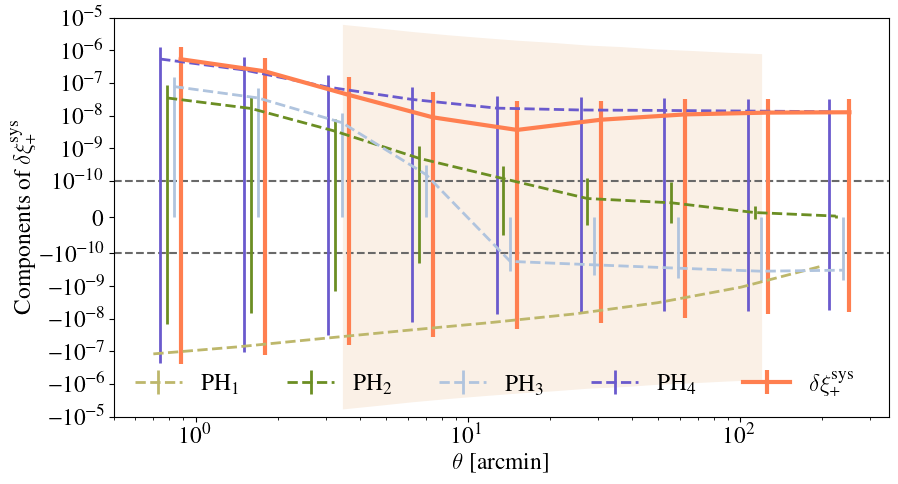

In [9]:
#for i in range(num_zbins_tot):
Plot_deltaxips_Only(9)


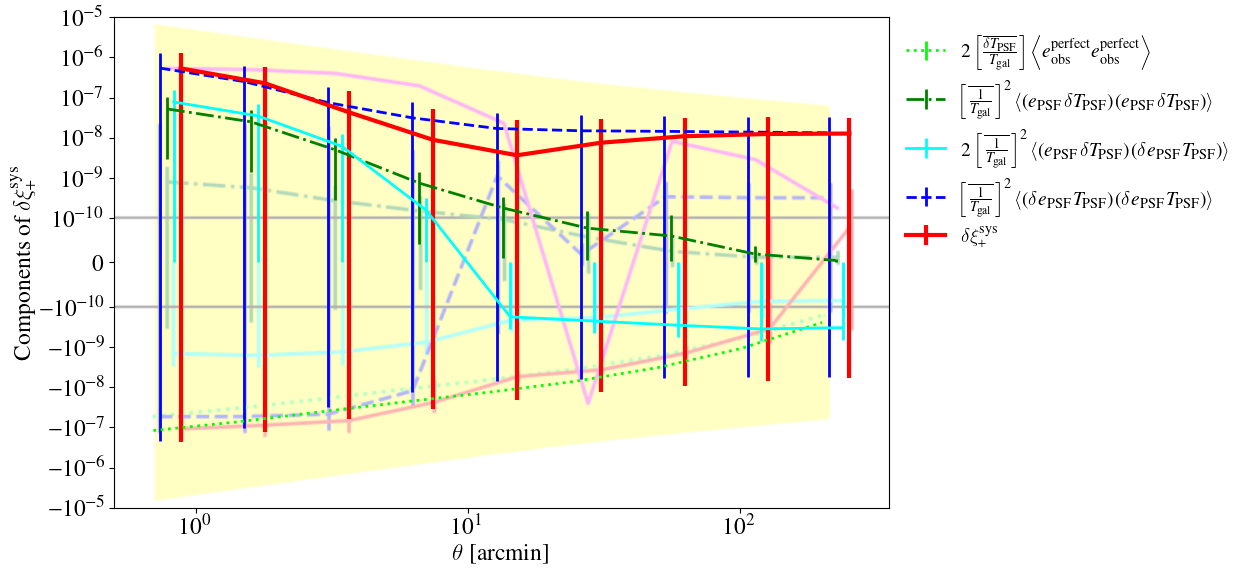

In [10]:
zbin =9

import matplotlib.ticker as ticker

fig = plt.figure(figsize=(10,10))
img = plt.imread("/pscratch/sd/j/jjeffers/PHSTATISTICS/phgiblin.png")
#gs1 = gridspec.GridSpec(2, 1, height_ratios=[0.05,0.95]) #[0.15,0.85]
#ax = plt.subplot(gs1[1], adjustable='box')
#set first axes
ax = fig.add_subplot(1,1,1)
#ax.set_xscale('log')
#ax.set_xlim([0.5,350.])
ax.imshow(img,  aspect='equal',alpha=0.3)
plt.axis('off')

#create second axes
newax = fig.add_axes(ax.get_position(), frameon=True)
newax.patch.set_alpha(0.0)
newax.set_ylim([-1*1e-5, 1e-5])
newax.set_xlim([0.5,350.])
newax.set_ylabel(r'Components of $\delta\xi_+^{\rm sys}$')
newax.set_xlabel(r'$\theta$ [arcmin]')
symlogscale=1e-10
newax.set_yscale('symlog', linthresh=symlogscale )
newax.set_xscale('log')

#Change formatting of xticks
newax.xaxis.set_minor_formatter(ticker.FormatStrFormatter('%.1f'))
#plot point
delta_xip_H, err_delta_xip_H, delta_xip_terms_H, err_delta_xip_terms_H = Calc_delta_xip_H20( php_mean, php_err )

plt.errorbar( 10**(np.log10(theta)-0.05), delta_xip_terms_H[ zbin,:,0],
                     yerr=err_delta_xip_terms_H[ zbin,:,0],
                     color='lime', linewidth=2, linestyle=':', 
		     label=r'$ 2 \left[{\frac{\overline{\delta T_{\rm PSF}}}{T_{\rm gal}}}\right] \left< e_{\rm obs}^{\rm perfect} e_{\rm obs}^{\rm perfect} \right>$' )

plt.errorbar( theta, 1.5*delta_xip_terms_H[ zbin,:,1],
             yerr=err_delta_xip_terms_H[ zbin,:,1],
             color='green', linewidth=2, linestyle='-.',
     label=r'$\left[ \,\overline{\frac{1}{T_{\rm gal}}}\,\right]^2 \left< (e_{\rm PSF} \, \delta T_{\rm PSF}) \,  (e_{\rm PSF} \, \delta T_{\rm PSF}) \right>$' )

plt.errorbar( 10**(np.log10(theta)+0.025), delta_xip_terms_H[ zbin,:,2],
             yerr=err_delta_xip_terms_H[ zbin,:,2],
             color='cyan', linewidth=2, linestyle='-',
     label=r'$2 \left[ \,\overline{\frac{1}{T_{\rm gal}}}\,\right]^2  \left< (e_{\rm PSF} \, \delta T_{\rm PSF}) \,  (\delta e_{\rm PSF} \, T_{\rm PSF}) \right>$' )

plt.errorbar( 10**(np.log10(theta)-0.025), delta_xip_terms_H[ zbin,:,3],
             yerr=err_delta_xip_terms_H[ zbin,:,3],
             color='blue', linewidth=2, linestyle='--',
             label=r'$\left[ \,\overline{\frac{1}{T_{\rm gal}}}\,\right]^2 \left< (\delta e_{\rm PSF} \, T_{\rm PSF}) \,  (\delta e_{\rm PSF} \,T_{\rm PSF}) \right>$' )
plt.errorbar( 10**(np.log10(theta)+0.05), delta_xip_H[ zbin,:],
                     yerr=err_delta_xip_H[ zbin,:], color='red', linewidth=3, #'red', 2
                     label=r'$\delta\xi_+^{\rm sys}$' ) # label=r'PH08')
plt.gca().minorticks_off()
newax.legend(bbox_to_anchor=(1, 1), frameon=False, ncol=1, fontsize=14)
plt.subplots_adjust()
plt.show()